In [1]:
import numpy as np 
import pandas as pd #
from sklearn.utils.multiclass import unique_labels
import os

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
#keras import 
from keras import Sequential
from keras.applications import DenseNet121
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [4]:
#Import dataset
from keras.datasets import cifar10


In [5]:
#Divide the data in Train, Validation and Test Datasets
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

In [6]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)


In [7]:
#Print the dimensions of the datasets to make sure everything's kosher

print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


In [8]:
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

In [31]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [9]:
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 10))
((15000, 32, 32, 3), (15000, 10))
((10000, 32, 32, 3), (10000, 10))


In [10]:
#Data Augmentation 

train_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1 )

val_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1)

test_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip= True,
                                    zoom_range=.1) 

In [11]:
#Fit the augmentation method to the data

train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [12]:
#learning rate Annealer
lrr= ReduceLROnPlateau(
                       monitor='val_acc', #Metric to be measured
                       factor=.01, #Factor by which learning rate will be reduced
                       patience=3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-5) #The minimum learning rate 

In [13]:
basemodel=DenseNet121( include_top=False,
    weights="imagenet",
    input_shape=(32,32,3),
    classes=y_train.shape[1])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [14]:
model_1= Sequential()
model_1.add(basemodel) #Adds the base model (in this case densenet121 to model_1)
model_1.add(Flatten()) 

In [15]:
model_1.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1, 1, 1024)        7037504   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
Total params: 7,037,504
Trainable params: 6,953,856
Non-trainable params: 83,648
_________________________________________________________________


In [16]:
#Add the Dense layers along with activation and batch normalization
model_1.add(Dense(1024,activation=('relu'),input_dim=512))
model_1.add(Dense(512,activation=('relu'))) 
model_1.add(Dense(256,activation=('relu'))) 
#model_1.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
model_1.add(Dense(128,activation=('relu')))
#model_1.add(Dropout(.2))
model_1.add(Dense(10,activation=('softmax'))) #This is the classification layer

In [17]:
model_1.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1, 1, 1024)        7037504   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

In [18]:
batch_size= 100
epochs=10
learn_rate=.001

sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [19]:
model_1.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
model_1.fit_generator(train_generator.flow(x_train,y_train,batch_size=batch_size),
                      epochs=epochs,
                      steps_per_epoch=x_train.shape[0]//batch_size,
                      validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),validation_steps=250,
                      callbacks=[lrr],verbose=1)


Epoch 1/10
350/350 [==============================] - 143s 409ms/step - loss: 1.4470 - accuracy: 0.4929 - val_loss: 1.0801 - val_accuracy: 0.6464


/home/gaurav/anaconda3/envs/myenv/lib/python3.6/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/10
350/350 [==============================] - 117s 334ms/step - loss: 0.8084 - accuracy: 0.7201 - val_loss: 0.7426 - val_accuracy: 0.7132
Epoch 3/10
350/350 [==============================] - 122s 349ms/step - loss: 0.6261 - accuracy: 0.7849 - val_loss: 0.6929 - val_accuracy: 0.7717
Epoch 4/10
350/350 [==============================] - 120s 344ms/step - loss: 0.5250 - accuracy: 0.8169 - val_loss: 0.6957 - val_accuracy: 0.7772
Epoch 5/10
350/350 [==============================] - 119s 341ms/step - loss: 0.4556 - accuracy: 0.8442 - val_loss: 0.6481 - val_accuracy: 0.8037
Epoch 6/10
350/350 [==============================] - 133s 379ms/step - loss: 0.3904 - accuracy: 0.8651 - val_loss: 0.5728 - val_accuracy: 0.8025
Epoch 7/10
350/350 [==============================] - 139s 398ms/step - loss: 0.3444 - accuracy: 0.8784 - val_loss: 0.6877 - val_accuracy: 0.8094
Epoch 8/10
350/350 [==============================] - 138s 394ms/step - loss: 0.3005 - accuracy: 0.8950 - val_loss: 0.5280 -

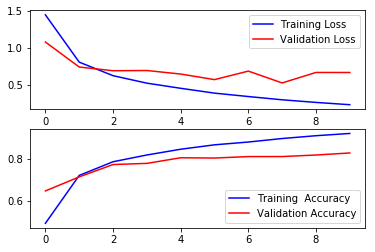

In [21]:
f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assign the first subplot to graph training loss and validation loss
ax[0].plot(model_1.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model_1.history.history['val_loss'],color='r',label='Validation Loss')
ax[0].legend()

#Next lets plot the training accuracy and validation accuracy
ax[1].plot(model_1.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model_1.history.history['val_accuracy'],color='r',label='Validation Accuracy')
ax[1].legend()


In [24]:
# serialize model to JSON
model_json = model_1.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_1.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [36]:
y_pred=model_1.predict_classes(x_test)
y_true=np.argmax(y_test,axis=1)

In [46]:
report=classification_report(y_true,y_pred)


In [49]:
print(report)

              precision    recall  f1-score   support

           0       0.81      0.89      0.84      1000
           1       0.87      0.91      0.89      1000
           2       0.77      0.77      0.77      1000
           3       0.70      0.63      0.67      1000
           4       0.78      0.78      0.78      1000
           5       0.81      0.68      0.74      1000
           6       0.77      0.92      0.84      1000
           7       0.87      0.84      0.85      1000
           8       0.91      0.90      0.90      1000
           9       0.89      0.87      0.88      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



In [51]:
confusion_matrix(y_true,y_pred)

array([[886,  16,  24,   3,  10,   2,   4,   6,  32,  17],
       [ 18, 910,   3,   3,   0,   2,   5,   3,   9,  47],
       [ 50,   3, 774,  27,  43,  18,  56,  19,   6,   4],
       [ 26,  10,  56, 633,  54,  87,  89,  24,  10,  11],
       [ 18,   1,  60,  28, 784,  11,  65,  25,   5,   3],
       [ 14,   4,  26, 155,  45, 678,  38,  34,   2,   4],
       [  8,   2,  26,  18,  13,   3, 924,   3,   2,   1],
       [ 14,   4,  24,  24,  43,  33,   8, 837,   5,   8],
       [ 44,  29,   6,   2,   4,   1,   1,   3, 895,  15],
       [ 20,  62,   1,   6,   3,   4,   4,  10,  17, 873]])